# Implementing Neural Network from scratch in Python 

## Purpose of this lab:
- understanding of how neural networks work, and that is essential for designing effective models.


## Generating data set
- We are using make_moon function from scikit-learn library as our dataset
- Visualise our data set by creating scatter plot using matplotlib library


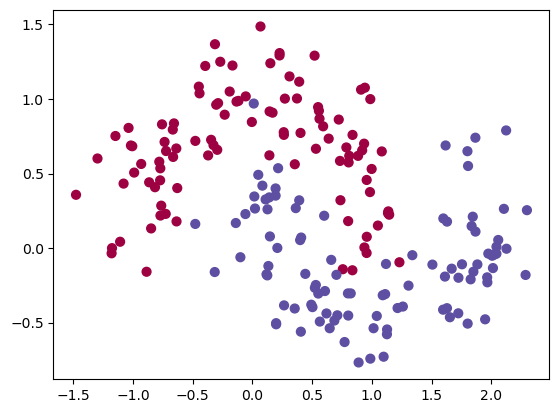

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from mlxtend.plotting import plot_decision_regions # type: ignore

# Generate a moon-shaped dataset and plot it
np.random.seed(0)
X, y = datasets.make_moons(n_samples=200, noise=0.2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

### Dataset Overview

We generated a dataset with two classes, represented as red and blue points. The blue dots represent male patients, and the red dots represent female patients. The x- and y- axes correspond to medical measurements.

### Goal

The goal is to train a machine learning classifier that can predict the correct class (male or female) based on the x- and y- coordinates.

### Challenge

The dataset is **not linearly separable**, meaning that a straight line cannot separate the two classes. This presents a challenge for **linear classifiers**, such as **Logistic Regression**, which would not be able to fit the data unless we manually engineer non-linear features (such as polynomials) that work well for the dataset.

### Advantage of Neural Networks

One of the major advantages of **Neural Networks** is that they do not require manual feature engineering. The **hidden layer** of a neural network will automatically learn the relevant features to separate the classes, making it well-suited for non-linear data like this.


Text(0.5, 1.0, 'Logistic Regression')

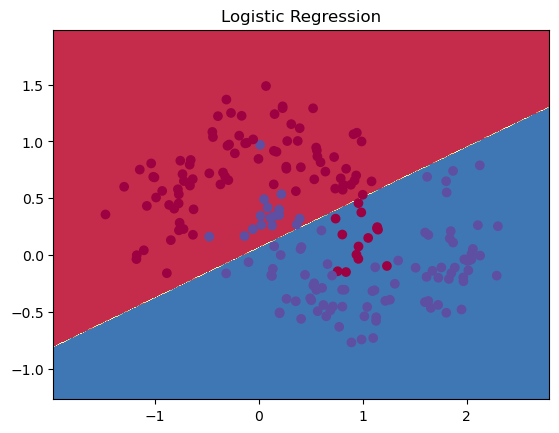

In [2]:
clf = LogisticRegressionCV()
clf.fit(X,y)

def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
plot_decision_boundary(lambda x: clf.predict(x)) 
plt.title("Logistic Regression") 

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it’s unable to capture the “moon shape” of our data.

# 3-Layer Neural Network for Classification

## Overview

This project implements a simple 3-layer neural network with:
- **Input Layer**: 2-dimensional input data (e.g., x- and y-coordinates).
- **Hidden Layer**: A customizable number of nodes to adjust model complexity.
- **Output Layer**: Produces probabilities for two classes: class 0 ("female") and class 1 ("male").

### Activation Functions
- **Hidden Layer**: Uses `tanh` for non-linear transformations.
- **Output Layer**: Uses `softmax` to convert raw scores into probabilities.

---

## Neural Network Forward Propagation

1. **Hidden Layer Computation**:
   $$
   z_1 = xW_1 + b_1
   $$
   $$
   a_1 = \tanh(z_1)
   $$

2. **Output Layer Computation**:
   $$
   z_2 = a_1W_2 + b_2
   $$
   $$
   a_2 = \text{softmax}(z_2)
   $$

### Explanation:
- **$z_1$ and $z_2$**: Weighted sums computed for the hidden and output layers.
- **$a_1$ and $a_2$**: Activations after applying the respective activation functions.
- **$W_1$, $b_1$, $W_2$, $b_2$**: Learnable weights and biases of the neural network.

### Example Matrix Dimensions:
If the hidden layer has 500 nodes, the dimensions of the parameters are as follows:

- $$ W_1 \in \mathbb{R}^{2 \times 500} $$ (maps 2 input features to 500 hidden nodes).  
- $$ b_1 \in \mathbb{R}^{500} $$ (one bias value per hidden node).  
- $$ W_2 \in \mathbb{R}^{500 \times 2} $$ (maps 500 hidden nodes to 2 output nodes).  
- $$ b_2 \in \mathbb{R}^{2} $$ (one bias value per output node).  

---

## Loss Function: Cross-Entropy

The model uses **categorical cross-entropy loss** to measure prediction error:
$$
L(y, \hat{y}) = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{n,i} \log(\hat{y}_{n,i})
$$

Where:
- **$N$**: Number of training samples.
- **$C$**: Number of classes.
- **$y_{n,i}$**: True label for sample \( n \).
- **$\hat{y}_{n,i}$**: Predicted probability for sample \( n \) and class \( i \).

---

## Gradient Descent and Backpropagation

To optimize the loss function, we use **gradient descent**. Gradients are computed using backpropagation:

1. **Output Layer Error**:
   $$
   \delta_3 = \hat{y} - y
   $$

2. **Hidden Layer Error**:
   $$
   \delta_2 = (1 - \tanh^2(z_1)) \circ \delta_3 W_2^T
   $$

3. **Gradients**:
   $$
   \frac{\partial L}{\partial W_2} = a_1^T \delta_3
   $$
   $$
   \frac{\partial L}{\partial b_2} = \delta_3
   $$
   $$
   \frac{\partial L}{\partial W_1} = x^T \delta_2
   $$
   $$
   \frac{\partial L}{\partial b_1} = \delta_2
   $$

---

## Training Procedure

Using the gradients, we update the weights and biases iteratively:
$$
\theta \gets \theta - \alpha \nabla_\theta L
$$
Where:
- **$\theta$**: Represents the parameters \( W_1, b_1, W_2, b_2 \).
- **$\alpha$**: Learning rate.

Training typically involves using **stochastic gradient descent** (SGD) or mini-batch gradient descent for efficiency.

---

By minimizing the loss and updating the parameters iteratively, the network learns to classify the input data accurately.


In [3]:
# Initialisation
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 2
epsilon = 0.01

In [4]:
"""
Helper function: 
- calculate_loss(model): compute the total loss for the entire dataset
- predict(model, x): predict the class for a given input x
"""
# Helper function to evaluate the total loss on the dataset 
def calculate_loss(model): 
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2'] 
    # Forward propagation to calculate our predictions 
    z1 = X.dot(W1) + b1 
    a1 = np.tanh(z1) 
    z2 = a1.dot(W2) + b2 
    exp_scores = np.exp(z2) 
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    # Calculating the loss 
    correct_logprobs = -np.log(probs[range(num_examples), y]) 
    data_loss = np.sum(correct_logprobs) 
    return 1. / num_examples * data_loss


# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

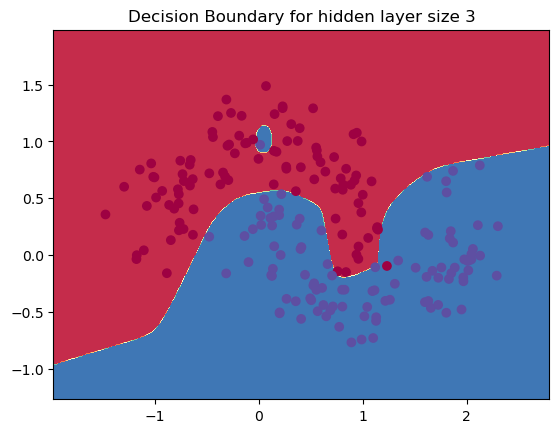

In [5]:
"""
Main function:
- build model: This function learns parameters for the neural network and returns the model.
   - nn_hdim: Number of nodes in the hidden layer
   - num_passes: Number of passes through the training data for gradient descent
"""
# Implements batch gradient descent using backpropagation 
def build_model(nn_hdim, num_passes=20000):
    # Initialise the parameters to random values. We need to learn these.
    np.random.seed(42)
    # W1: matrix size number_hidden_nodes of current layer x number_nodes of previous layer 
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) 
    b1 = np.zeros((1, nn_hdim)) 
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim) 
    b2 = np.zeros((1, nn_output_dim))
    # This is what we return at the end
    model = {}
    # Gradient descent. For each batch
    for i in range(0, num_passes):
        # Forward propagation 
        z1 = X.dot(W1) + b1 
        a1 = np.tanh(z1) 
        z2 = a1.dot(W2) + b2 
        exp_scores = np.exp(z2) 
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
        # Backpropagation 
        delta3 = probs 
        delta3[range(num_examples), y] -= 1 
        dW2 = (a1.T).dot(delta3) 
        db2 = np.sum(delta3, axis=0, keepdims=True) 
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2)) 
        dW1 = np.dot(X.T, delta2) 
        db1 = np.sum(delta2, axis=0) 

        # Gradient descent parameter update (no regularization term)
        W1 += -epsilon * dW1 
        b1 += -epsilon * db1 
        W2 += -epsilon * dW2 
        b2 += -epsilon * db2 

        # Assign new parameters to the model 
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2} 
    return model

model = build_model(9)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")